In [7]:
from qpipe.cost_model import LatCostModel
from qpipe.partitioner import gen_config
global_bz = gen_config.global_bz
micro_bz = gen_config.micro_bz
s = gen_config.s
n = gen_config.n

profiled_result_folder = '/workspace/qpipe/scripts/lat_profiled_result/'
device_names = ['Tesla_V100-SXM2-32GB', 'NVIDIA_A100-SXM4-40GB', 'Tesla_P100-PCIE-12GB']
lat_cost_model = LatCostModel(device_names)
lat_cost_model.update_profiled_result(profiled_result_folder)
lat_cost_model.fit_regression_cost_model()
lat_cost_model.load_regression_cost_model()
lat_cost_model.verbose_regression_names()

Tesla_V100-SXM2-32GB_2_14336_57344_1_3.pkl
MSE: 1.7424
Tesla_V100-SXM2-32GB_2_14336_57344_128_3.pkl
MSE: 78.8226
Tesla_V100-SXM2-32GB_2_14336_57344_512_3.pkl
MSE: 409.5522
Tesla_V100-SXM2-32GB_2_14336_57344_1_4.pkl
MSE: 1.5951
Tesla_V100-SXM2-32GB_2_14336_57344_128_4.pkl
MSE: 28.5934
Tesla_V100-SXM2-32GB_2_14336_57344_512_4.pkl
MSE: 556.0804
Tesla_V100-SXM2-32GB_2_14336_57344_1_8:tc-li.pkl
MSE: 1.8176
Tesla_V100-SXM2-32GB_2_14336_57344_128_8:tc-li.pkl
MSE: 23.6152
Tesla_V100-SXM2-32GB_2_14336_57344_512_8:tc-li.pkl
MSE: 35.3110
Tesla_V100-SXM2-32GB_2_14336_57344_1_16.pkl
MSE: 1.7434
Tesla_V100-SXM2-32GB_2_14336_57344_128_16.pkl
MSE: 615.8033
Tesla_V100-SXM2-32GB_2_14336_57344_512_16.pkl
MSE: 1203.4269
Tesla_V100-SXM2-32GB_2_7168_28672_1_3.pkl
MSE: 0.2826
Tesla_V100-SXM2-32GB_2_7168_28672_128_3.pkl
MSE: 0.6462
Tesla_V100-SXM2-32GB_2_7168_28672_512_3.pkl
MSE: 14.8948
Tesla_V100-SXM2-32GB_2_7168_28672_1_4.pkl
MSE: 0.2145
Tesla_V100-SXM2-32GB_2_7168_28672_128_4.pkl
MSE: 0.6801
Tesla_V100-SX

In [8]:
# load groud truth
import pandas as pd
A100_file = 'NVIDIA_A100-SXM4-40GB_30b_test.csv'
P100_file = 'Tesla_P100-PCIE-12GB_30b_test.csv'
V100_file = 'Tesla_V100-SXM2-32GB_30b_test.csv'
groud_t_A100 = pd.read_csv(A100_file)
groud_t_P100 = pd.read_csv(P100_file)
groud_t_V100 = pd.read_csv(V100_file)

In [9]:
# test
predict_lat = lat_cost_model.predict('Tesla_V100-SXM2-32GB', 2, 16, s, 0, 7168, 28672, 4)
groud_lat = lat_cost_model.fetch_lat('Tesla_V100-SXM2-32GB', 2, 16, s, 0, 7168, 28672, 4)
print(predict_lat, groud_lat)

4494.22984182538 4480.748987197876


In [10]:
def get_ground_and_predicts(groud_t, device_name = 'NVIDIA_A100-SXM4-40GB'):
    shard = 2
    predict_points = []
    ground_points = []
    for index, row in groud_t.iterrows():
        batch_size = row['batch_size']
        s = row['input_seq_length']
        past_seq_length = row['past_seq_length']
        h1, h2 = row['h1'], row['h2']
        bit = row['bit']
        lat = row['lat_avg']
        ground_points.append(lat)
        predict_points.append(lat_cost_model.predict(device_name, shard, batch_size, s, past_seq_length, h1, h2, bit))
    return ground_points, predict_points


In [11]:
ground_points_A, predict_points_A = get_ground_and_predicts(groud_t_A100, 'NVIDIA_A100-SXM4-40GB')
ground_points_P, predict_points_P = get_ground_and_predicts(groud_t_P100, 'Tesla_P100-PCIE-12GB')
ground_points_V, predict_points_V = get_ground_and_predicts(groud_t_V100, 'Tesla_V100-SXM2-32GB')

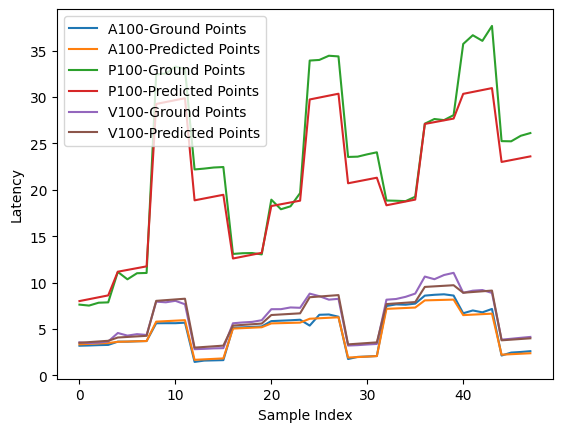

In [12]:
import matplotlib.pyplot as plt

plt.plot(ground_points_A, label='A100-Ground Points')
plt.plot(predict_points_A, label='A100-Predicted Points')
plt.plot(ground_points_P, label='P100-Ground Points')
plt.plot(predict_points_P, label='P100-Predicted Points')
plt.plot(ground_points_V, label='V100-Ground Points')
plt.plot(predict_points_V, label='V100-Predicted Points')
plt.xlabel('Sample Index')
plt.ylabel('Latency')
# plt.title('Ground vs Predicted Points for Device {} and Shard {}'.format(device_name, shard))
plt.legend()
plt.savefig('lat_cost_model.pdf')
plt.show()